# Application of `moscot.spatiotemporal` to MOSTA w/ `CellRank`


Uses `moscot.spatiotemporal` mappings between time points to create a CellRank kernel. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
from datetime import datetime
import glob
import numpy as np
from copy import copy
import pickle
from matplotlib.colors import ListedColormap
import matplotlib.collections as collections
import colorcet as cc

from scipy.sparse import hstack as sparse_hstack
from scipy.sparse import vstack as sparse_vstack
from scipy.sparse import csr_matrix, block_diag, dok_matrix

import scanpy as sc
import anndata
import squidpy as sq
import cellrank as cr
import pandas as pd


import seaborn as sns
from matplotlib import colors as mcolors, pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.stats import entropy
from cellrank.estimators import GPCCA

from typing import *
from types import MappingProxyType

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
cr.logging.print_version_and_date()

Running CellRank 1.5.1+g5853d0e0, on 2023-05-02 00:05.


## Dependencies

Requires following steps in:

1. `0_Data_preparation/ZP_2023-04-20_spatiotemporal_fullembryo-preprocess.ipynb`: creates `mouse_embryo_all_stage_renormalized.h5ad`
2. `1_Cell_type_transition_analysis/1_mapping_across_timepoints`: creates `.pkl` transition matrices.

Files:
1. `Mus_musculus_TF.txt`: downloaded from [AnimalTFDB3.0](http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF)


## Define utility functions

Define a custom kernel class to convert moslin's couplings into a CellRank kernel.

In [6]:
class MostaKernel(cr.kernels.TransportMapKernel):
    
    def compute_transition_matrix(
        self,
        tmaps: Dict[Tuple[float, float], anndata.AnnData],
        threshold: Optional[str] = "auto",
        self_transitions: Union[
            Literal["uniform", "diagonal", "connectivities", "all"],
            Sequence[float],
        ] = "connectivities",
        conn_weight: Optional[float] = None,
        conn_kwargs: Mapping[str, Any] = MappingProxyType({}),
    ):
        self._tmaps = tmaps

        if threshold is not None:
            self._threshold_transport_maps(
                self.transport_maps, threshold=threshold, copy=False
            )

        tmap = self._restich_tmaps(
            self.transport_maps,
            self_transitions=self_transitions,
            conn_weight=conn_weight,
            **conn_kwargs,
        )

        self.transition_matrix = tmap.X
        return self

    def _compute_tmap(self):
        raise NotImplementedError()

Return a sorted df of driver genes, subsetted to the relevant columns.

In [7]:
def return_drivers(adata, states, q_thresh = None, n_genes = 20, gene_list = None, TF = False):
    state = states[0]
    cols = ['highly_variable', 'highly_variable_rank']
    for state in states:
        cols.append(f"{state}_pval")
        cols.append(f"{state}_corr")
    if q_thresh is not None:
        mask = adata.var[f"{state}_qval"] < q_thresh
    elif gene_list is not None:
        mask = adata.var_names.isin(gene_list)
    elif TF:
        mask = adata.var["TF"]
    else: 
        mask = np.ones(adata.n_vars).astype(bool)
    
    if gene_list is not None:
        gene_df = adata[:, mask].var.sort_values(by=f"{state}_corr", ascending=False)[cols]
    else:
        gene_df = adata[:, mask].var.sort_values(by=f"{state}_corr", ascending=False).head(n_genes)[cols]          
    return gene_df

## Set up paths

In [8]:
# sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

# from paths import DATA_DIR, FIG_DIR

# FIG_DIR = FIG_DIR / "mosta"
# DATA_DIR = DATA_DIR / "mosta"


DATA_DIR = "./data/"
FIG_DIR = "./figs/"

## Set global parameters

In [9]:
import mplscience
mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [10]:
DPI_SAVE = 400

In [11]:
save_figure = True

## Load processed

In [12]:
adata = sc.read(DATA_DIR + "mouse_embryo_all_stage_renormalized.h5ad")

In [13]:
tps = adata.obs["time"].unique()
tps_couple = [[i, i+1] for i in tps[:-1]]

## Cellrank analysis

In [14]:
filenames = glob.glob(str(DATA_DIR) + "tmats/*_tmat.pkl")
tmats = {}

for file in filenames:
    
    split_ = file.split("/")[-1].split("_")
    tp = int(split_[-2])
    start, end = tps_couple[tp]
    
    with open(file, "rb") as handle:
        tmat = pickle.load(handle)
    
    tmats[start, end] = anndata.AnnData(
        tmat, 
        obs=adata[adata.obs["time"] == start].obs.copy(), 
        var=adata[adata.obs["time"] == end].obs.copy()
    )

tmats = {(start, end): tmats[start, end] for start, end in tps_couple}       

In [15]:
tfs = pd.read_csv(DATA_DIR + "Mus_musculus_TF.txt", delimiter="\t")
adata.var["TF"] = adata.var_names.isin(tfs["Symbol"])

### Create kernel

In [16]:
mk = MostaKernel(adata, time_key="time").compute_transition_matrix(
    tmats, self_transitions="connectivities"
)
conn = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [17]:
kernel = 0.9 * mk + 0.1 * conn

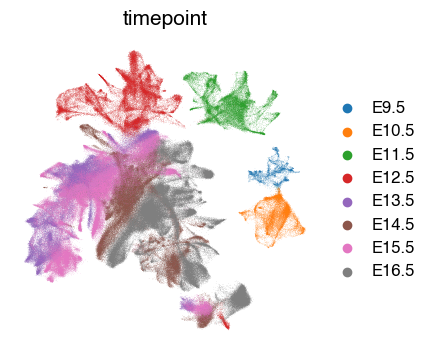

In [18]:
sc.pl.umap(adata, color="timepoint", show=False, frameon=False)

if save_figure:
    plt.savefig(FIG_DIR + "umap_time.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

### Create estimator

In [19]:
g = GPCCA(kernel)

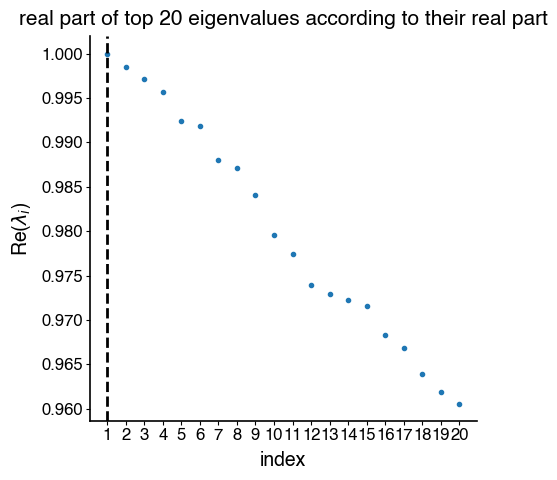

In [20]:
g.compute_schur()
g.plot_spectrum(real_only=True)

In [21]:
g.compute_macrostates(n_states=6, cluster_key="annotation")


GPCCA[kernel=(0.9 * MostaKernel[n=518684] + 0.1 * ConnectivityKernel[n=518684]), initial_states=None, terminal_states=None]

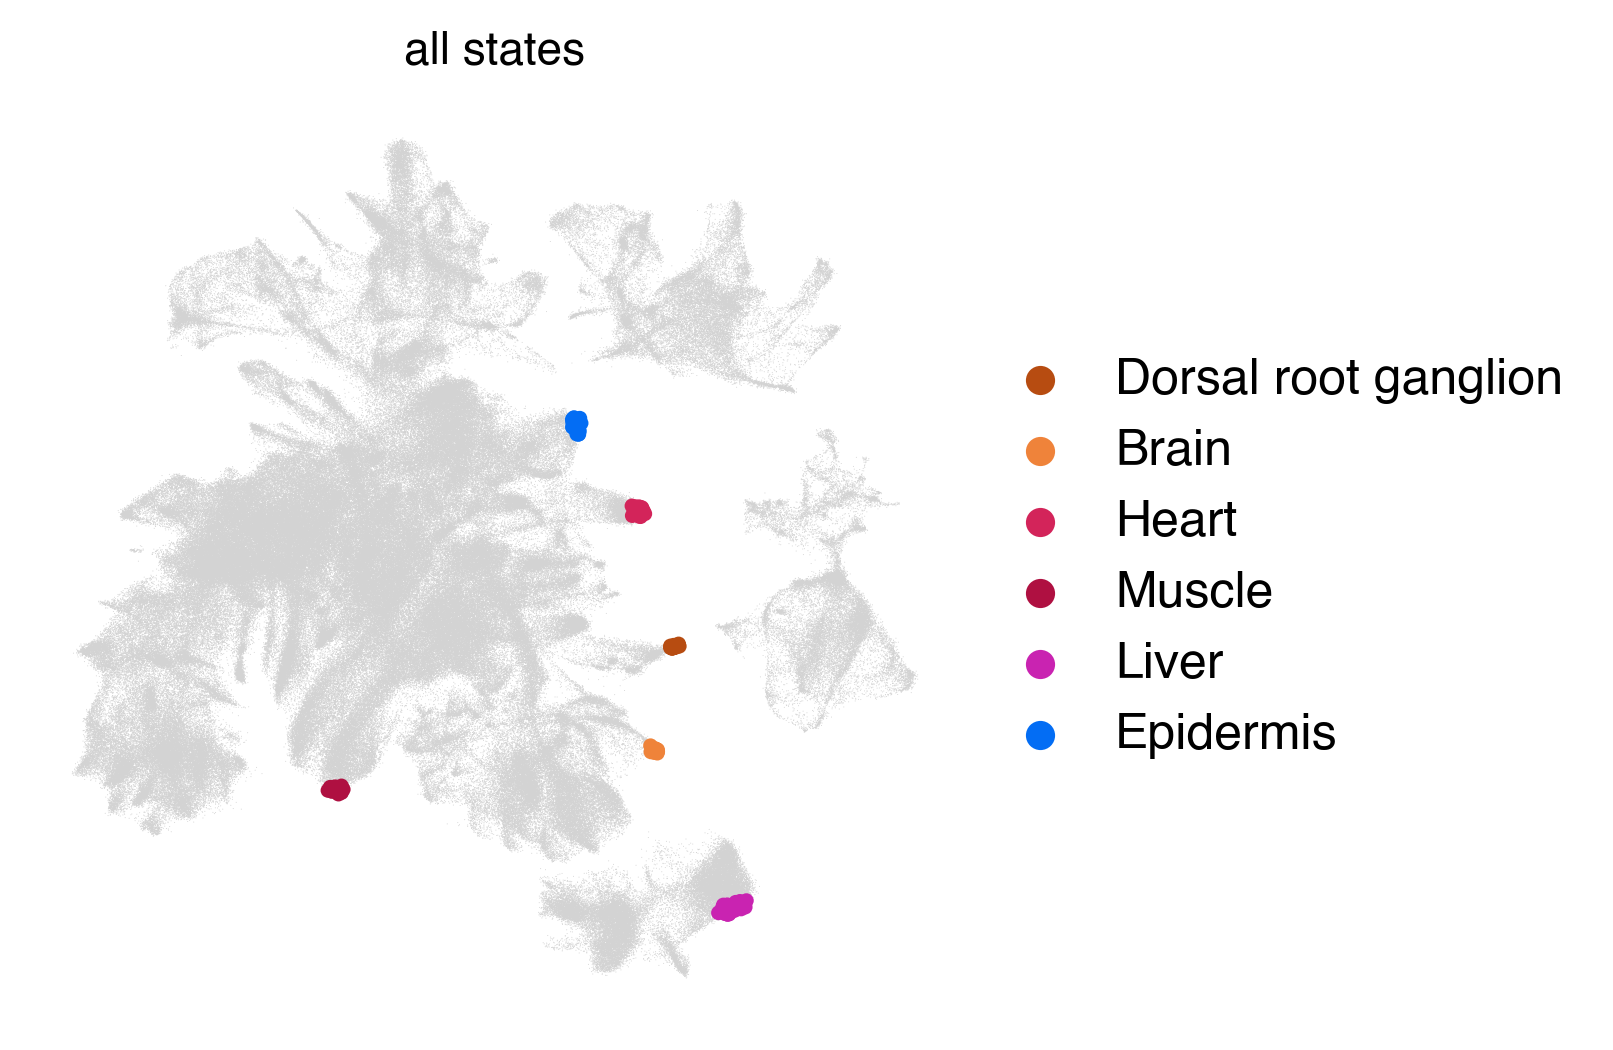

In [23]:
g.plot_macrostates(which="all", legend_loc="right", dpi=300, s=50, show=False)

if save_figure:
    plt.savefig(FIG_DIR + "macros.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

In [24]:
g.set_terminal_states(states=None)

GPCCA[kernel=(0.9 * MostaKernel[n=518684] + 0.1 * ConnectivityKernel[n=518684]), initial_states=None, terminal_states=['Brain', 'Dorsal root ganglion', 'Epidermis', 'Heart', 'Liver', 'Muscle']]

In [25]:
g.compute_absorption_probabilities()

  0%|          | 0/6 [00:00<?, ?/s]

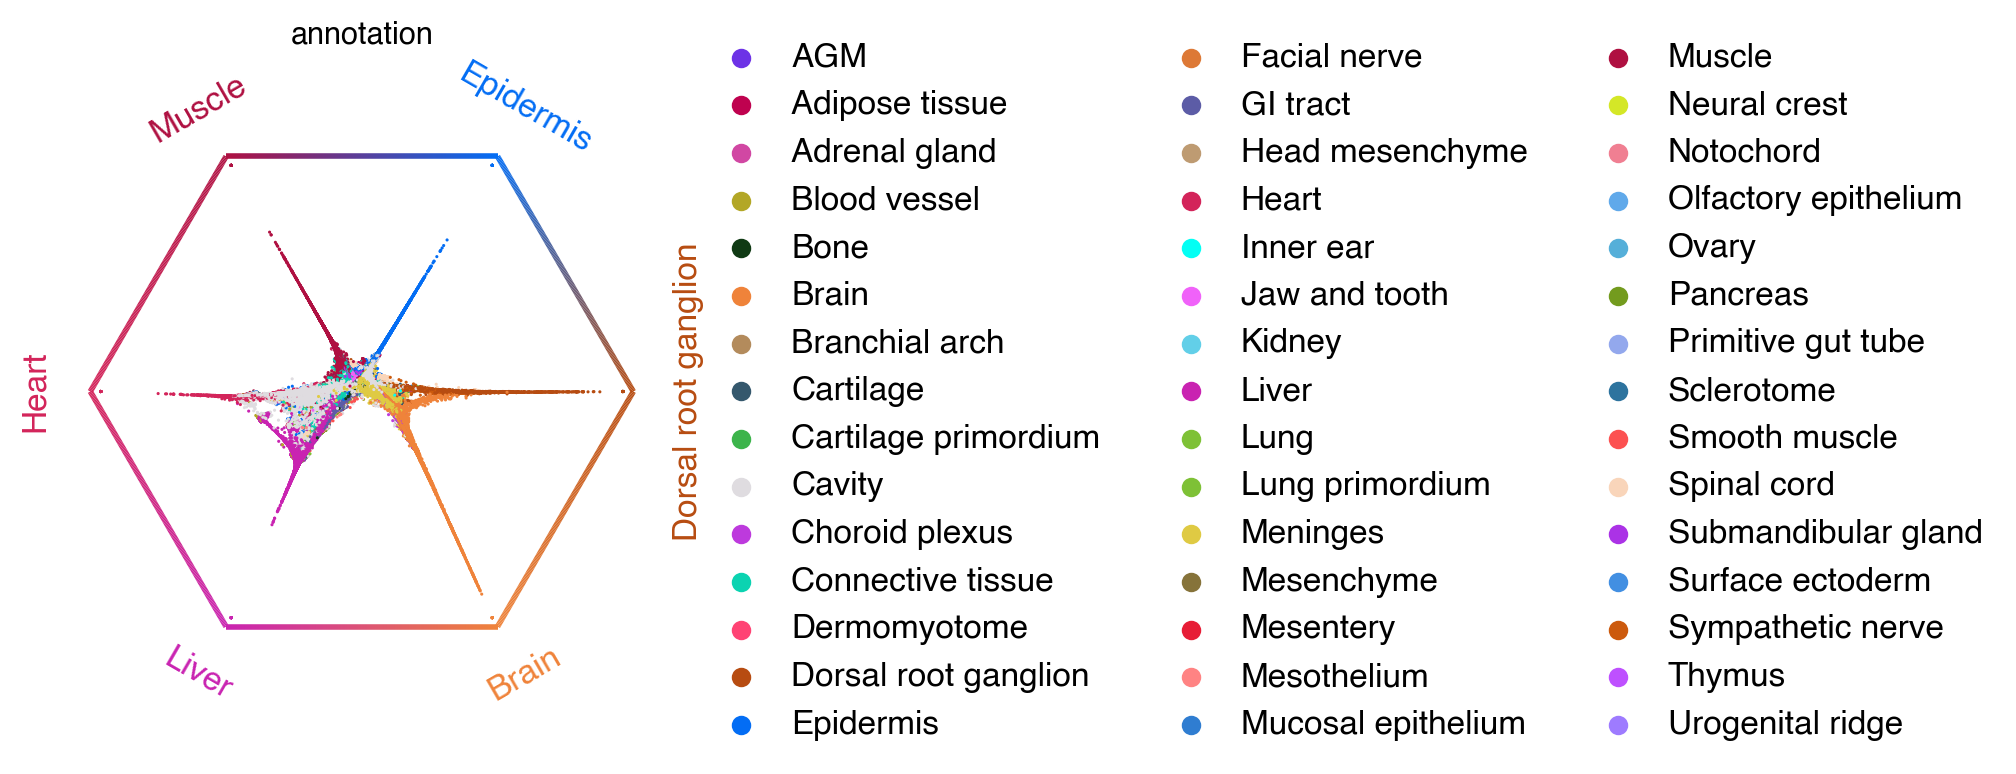

In [26]:
cr.pl.circular_projection(
    adata, keys="annotation", legend_loc="right", figsize=(20, 20), dpi=200, s=5
)


if save_figure:
    plt.savefig(FIG_DIR + "circular_projection.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

## Evaluate `heart` driver genes

In [27]:
corrs = g.compute_lineage_drivers()
corrs.head()

Dorsal root ganglion_corr  Dorsal root ganglion_pval  \
gene_short_name                                                         
Tuba1a                            0.478566                        0.0   
Stmn2                             0.448984                        0.0   
Map1b                             0.447120                        0.0   
Tubb2b                            0.439518                        0.0   
Tubb3                             0.438481                        0.0   

                 Dorsal root ganglion_qval  Dorsal root ganglion_ci_low  \
gene_short_name                                                           
Tuba1a                                 0.0                     0.476466   
Stmn2                                  0.0                     0.446809   
Map1b                                  0.0                     0.444940   
Tubb2b                                 0.0                     0.437320   
Tubb3                                  0.0                     0.436280   

                 Dorsal root ganglion_ci_high  Brain_corr  Brain_pval  \
gene_short_name                                                         
Tuba1a                               0.480662    0.508457         0.0   
Stmn2                                0.451154    0.416487         0.0   
Map1b                                0.449295    0.478091         0.0   
Tubb2b                               0.441711    0.521744         0.0   
Tubb3                                0.440677    0.460292         0.0   

                 Brain_qval  Brain_ci_low  Brain_ci_high  ...  Liver_corr  \
gene_short_name                                           ...               
Tuba1a                  0.0      0.506436       0.510472  ...   -0.320662   
Stmn2                   0.0      0.414236       0.418734  ...   -0.219110   
Map1b                   0.0      0.475989       0.480188  ...   -0.270925   
Tubb2b                  0.0      0.519761       0.523722  ...   -0.276583   
Tubb3                   0.0      0.458144       0.462434  ...   -0.218559   

                 Liver_pval  Liver_qval  Liver_ci_low  Liver_ci_high  \
gene_short_name                                                        
Tuba1a                  0.0         0.0     -0.323101      -0.318218   
Stmn2                   0.0         0.0     -0.221699      -0.216517   
Map1b                   0.0         0.0     -0.273445      -0.268402   
Tubb2b                  0.0         0.0     -0.279094      -0.274068   
Tubb3                   0.0         0.0     -0.221149      -0.215966   

                 Epidermis_corr  Epidermis_pval  Epidermis_qval  \
gene_short_name                                                   
Tuba1a                 0.123034    0.000000e+00    0.000000e+00   
Stmn2                  0.041359   3.489342e-195   3.288785e-194   
Map1b                  0.071530    0.000000e+00    0.000000e+00   
Tubb2b                 0.066298    0.000000e+00    0.000000e+00   
Tubb3                  0.027106    6.509056e-85    3.206753e-84   

                 Epidermis_ci_low  Epidermis_ci_high  
gene_short_name                                       
Tuba1a                   0.120353           0.125713  
Stmn2                    0.038642           0.044076  
Map1b                    0.068822           0.074237  
Tubb2b                   0.063588           0.069007  
Tubb3                    0.024387           0.029826  

[5 rows x 30 columns]

In [28]:
# Merge this on the `.var` annotation to have information about which of these are also TFs!
new_var = adata.var.merge(right=corrs, how='left', left_index=True, right_index=True)

# make sure the index is exactly the same as in adata.var
assert((adata.var.index == new_var.index).all()), "Indices do not fully overlap"

# put the new var anntations in place
adata.var = new_var

Top 20 `Heart` driver genes 

In [29]:
heart_df = return_drivers(adata, states=["Heart"])
heart_df

highly_variable  highly_variable_rank  Heart_pval  Heart_corr
gene_short_name                                                               
Myl7                        True                   6.0         0.0    0.377251
Hba-a1                      True                   8.0         0.0    0.362223
Myh6                        True                  28.0         0.0    0.356917
Hba-a2                      True                  10.0         0.0    0.352013
Alas2                       True                 523.0         0.0    0.340594
Hba-x                       True                   8.5         0.0    0.326682
Hbb-y                       True                  13.0         0.0    0.321721
Nppa                        True                  14.0         0.0    0.309587
Tnni3                       True                 151.0         0.0    0.297885
Hbb-bt                      True                   9.5         0.0    0.294465
Apex2                       True                 498.0         0.0    0.244115
Myl2                        True                   4.5         0.0    0.239341
Hbb-bs                      True                  12.0         0.0    0.237905
Tnnt2                       True                  34.0         0.0    0.232644
Ankrd1                      True                 261.0         0.0    0.228475
Myl3                        True                  20.0         0.0    0.226276
Mybpc3                      True                 273.0         0.0    0.226258
Fam46c                      True                 809.0         0.0    0.213848
Mkrn1                      False                1152.0         0.0    0.212575
Epb41                       True                 759.0         0.0    0.207070

Top 20 `Heart` TF driver genes 

In [30]:
heart_tf_df = return_drivers(adata, states=["Heart"], TF=True)
heart_tf_df

highly_variable  highly_variable_rank     Heart_pval  \
gene_short_name                                                         
Tbx20                      False                1104.0   0.000000e+00   
Nkx2-5                      True                 517.5   0.000000e+00   
Gata4                       True                 766.0   0.000000e+00   
Gata6                      False                1090.0   0.000000e+00   
Hand2                      False                1033.0   0.000000e+00   
Tbx5                       False                1536.0   0.000000e+00   
Hopx                        True                 215.0  4.981147e-120   
Prrx2                       True                 621.0   2.861745e-85   
Tfdp2                      False                   NaN   3.470091e-84   
Id3                         True                 514.0   2.277625e-77   
Myrf                       False                   NaN   1.392385e-70   
Hey2                       False                1864.0   2.740637e-65   
Gata5                      False                1832.0   1.217238e-63   
Tbx18                      False                1242.0   1.051077e-59   
Smad6                      False                1535.0   7.244168e-58   
Elk3                       False                   NaN   5.132878e-57   
Wt1                         True                 713.0   9.870388e-56   
Gsc                        False                 901.0   6.798017e-52   
Creb3l2                    False                1829.5   2.011363e-51   
Ybx3                       False                   NaN   2.953060e-50   

                 Heart_corr  
gene_short_name              
Tbx20              0.127559  
Nkx2-5             0.103227  
Gata4              0.094618  
Gata6              0.070690  
Hand2              0.064197  
Tbx5               0.055519  
Hopx               0.032334  
Prrx2              0.027165  
Tfdp2              0.026988  
Id3                0.025846  
Myrf               0.024658  
Hey2               0.023689  
Gata5              0.023380  
Tbx18              0.022624  
Smad6              0.022262  
Elk3               0.022092  
Wt1                0.021834  
Gsc                0.021043  
Creb3l2            0.020944  
Ybx3               0.020696

In [32]:
heart_full = pd.concat((heart_tf_df, heart_df), keys=['TF', 'all genes']).reset_index().rename(columns={
    "level_0": "gene_set",
})[['gene_short_name', 'gene_set', 'Heart_pval', 'Heart_corr', 'highly_variable', 'highly_variable_rank']]
heart_full.to_csv(DATA_DIR + "Heart_drivers.csv")
heart_full

gene_short_name   gene_set     Heart_pval  Heart_corr  highly_variable  \
0            Tbx20         TF   0.000000e+00    0.127559            False   
1           Nkx2-5         TF   0.000000e+00    0.103227             True   
2            Gata4         TF   0.000000e+00    0.094618             True   
3            Gata6         TF   0.000000e+00    0.070690            False   
4            Hand2         TF   0.000000e+00    0.064197            False   
5             Tbx5         TF   0.000000e+00    0.055519            False   
6             Hopx         TF  4.981147e-120    0.032334             True   
7            Prrx2         TF   2.861745e-85    0.027165             True   
8            Tfdp2         TF   3.470091e-84    0.026988            False   
9              Id3         TF   2.277625e-77    0.025846             True   
10            Myrf         TF   1.392385e-70    0.024658            False   
11            Hey2         TF   2.740637e-65    0.023689            False   
12           Gata5         TF   1.217238e-63    0.023380            False   
13           Tbx18         TF   1.051077e-59    0.022624            False   
14           Smad6         TF   7.244168e-58    0.022262            False   
15            Elk3         TF   5.132878e-57    0.022092            False   
16             Wt1         TF   9.870388e-56    0.021834             True   
17             Gsc         TF   6.798017e-52    0.021043            False   
18         Creb3l2         TF   2.011363e-51    0.020944            False   
19            Ybx3         TF   2.953060e-50    0.020696            False   
20            Myl7  all genes   0.000000e+00    0.377251             True   
21          Hba-a1  all genes   0.000000e+00    0.362223             True   
22            Myh6  all genes   0.000000e+00    0.356917             True   
23          Hba-a2  all genes   0.000000e+00    0.352013             True   
24           Alas2  all genes   0.000000e+00    0.340594             True   
25           Hba-x  all genes   0.000000e+00    0.326682             True   
26           Hbb-y  all genes   0.000000e+00    0.321721             True   
27            Nppa  all genes   0.000000e+00    0.309587             True   
28           Tnni3  all genes   0.000000e+00    0.297885             True   
29          Hbb-bt  all genes   0.000000e+00    0.294465             True   
30           Apex2  all genes   0.000000e+00    0.244115             True   
31            Myl2  all genes   0.000000e+00    0.239341             True   
32          Hbb-bs  all genes   0.000000e+00    0.237905             True   
33           Tnnt2  all genes   0.000000e+00    0.232644             True   
34          Ankrd1  all genes   0.000000e+00    0.228475             True   
35            Myl3  all genes   0.000000e+00    0.226276             True   
36          Mybpc3  all genes   0.000000e+00    0.226258             True   
37          Fam46c  all genes   0.000000e+00    0.213848             True   
38           Mkrn1  all genes   0.000000e+00    0.212575            False   
39           Epb41  all genes   0.000000e+00    0.207070             True   

    highly_variable_rank  
0                 1104.0  
1                  517.5  
2                  766.0  
3                 1090.0  
4                 1033.0  
5                 1536.0  
6                  215.0  
7                  621.0  
8                    NaN  
9                  514.0  
10                   NaN  
11                1864.0  
12                1832.0  
13                1242.0  
14                1535.0  
15                   NaN  
16                 713.0  
17                 901.0  
18                1829.5  
19                   NaN  
20                   6.0  
21                   8.0  
22                  28.0  
23                  10.0  
24                 523.0  
25                   8.5  
26                  13.0  
27                  14.0  
28                 151.0  
29                   9.5  
30      

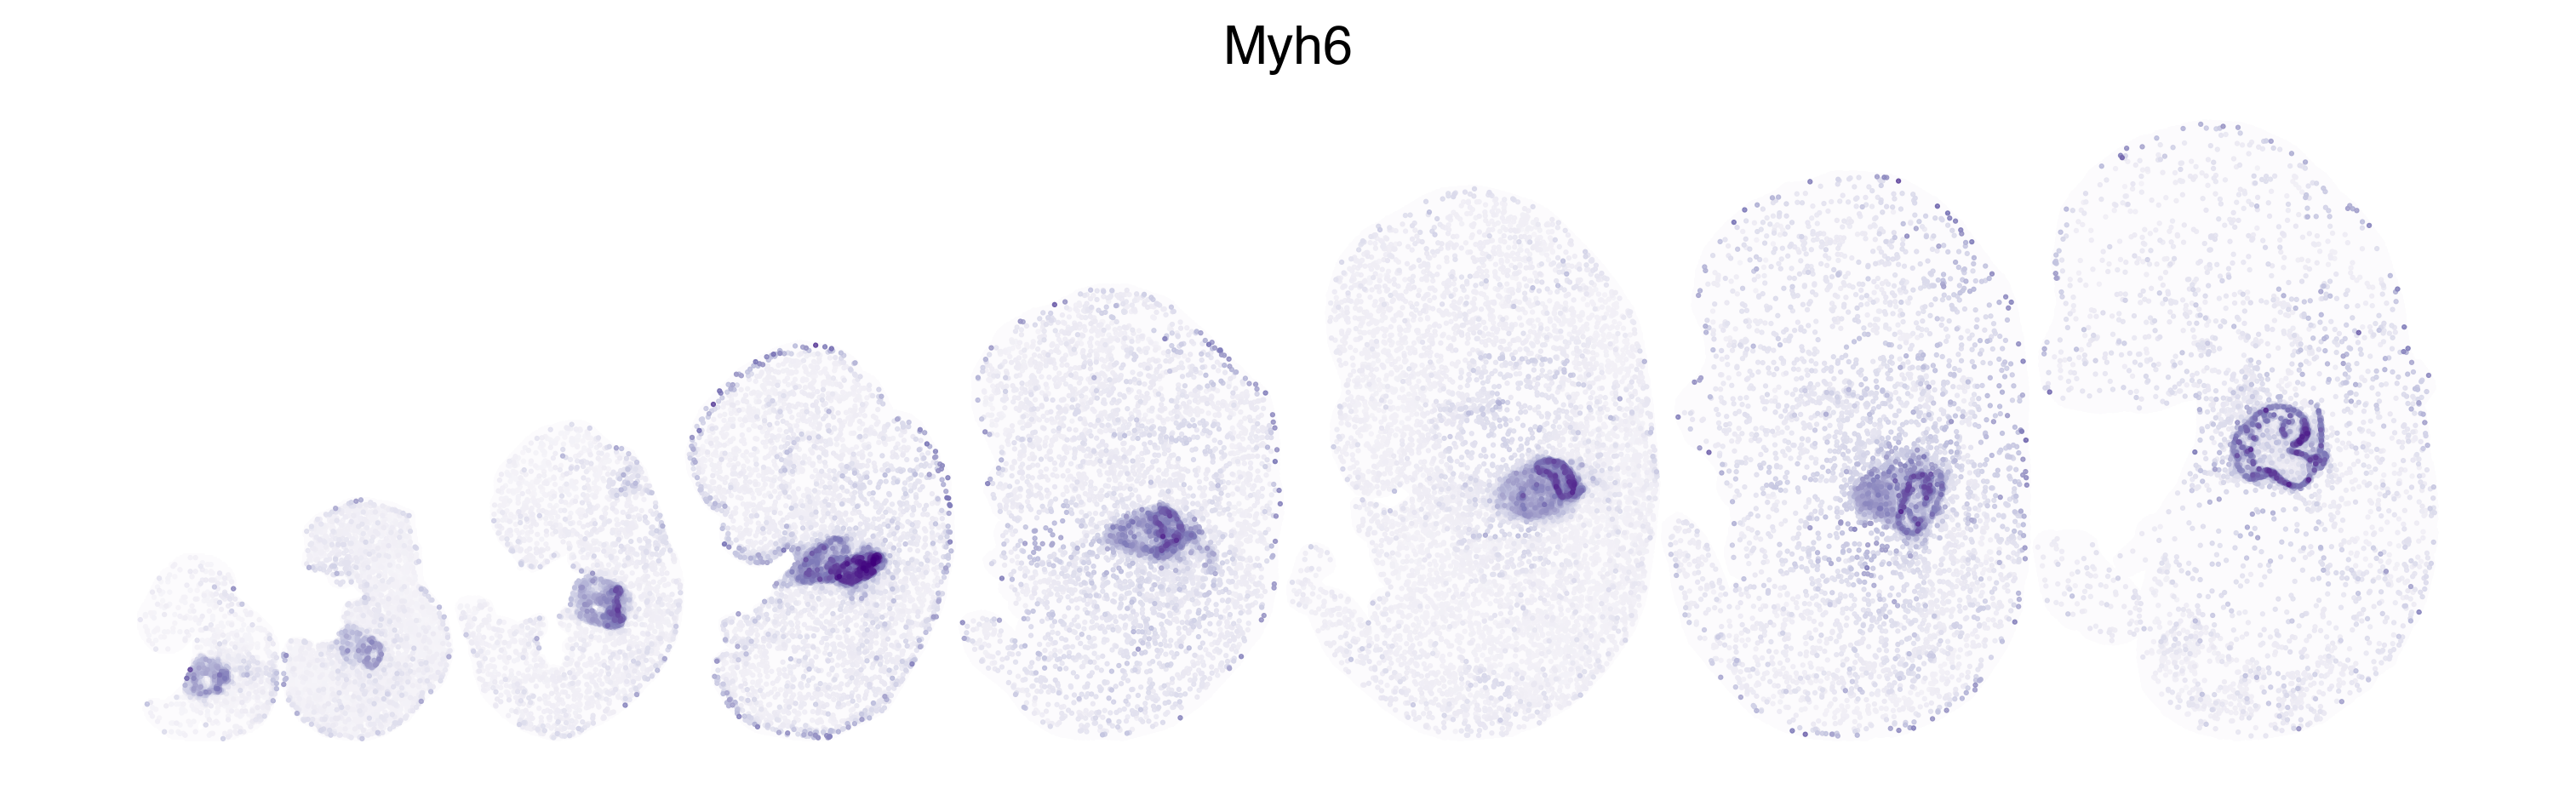

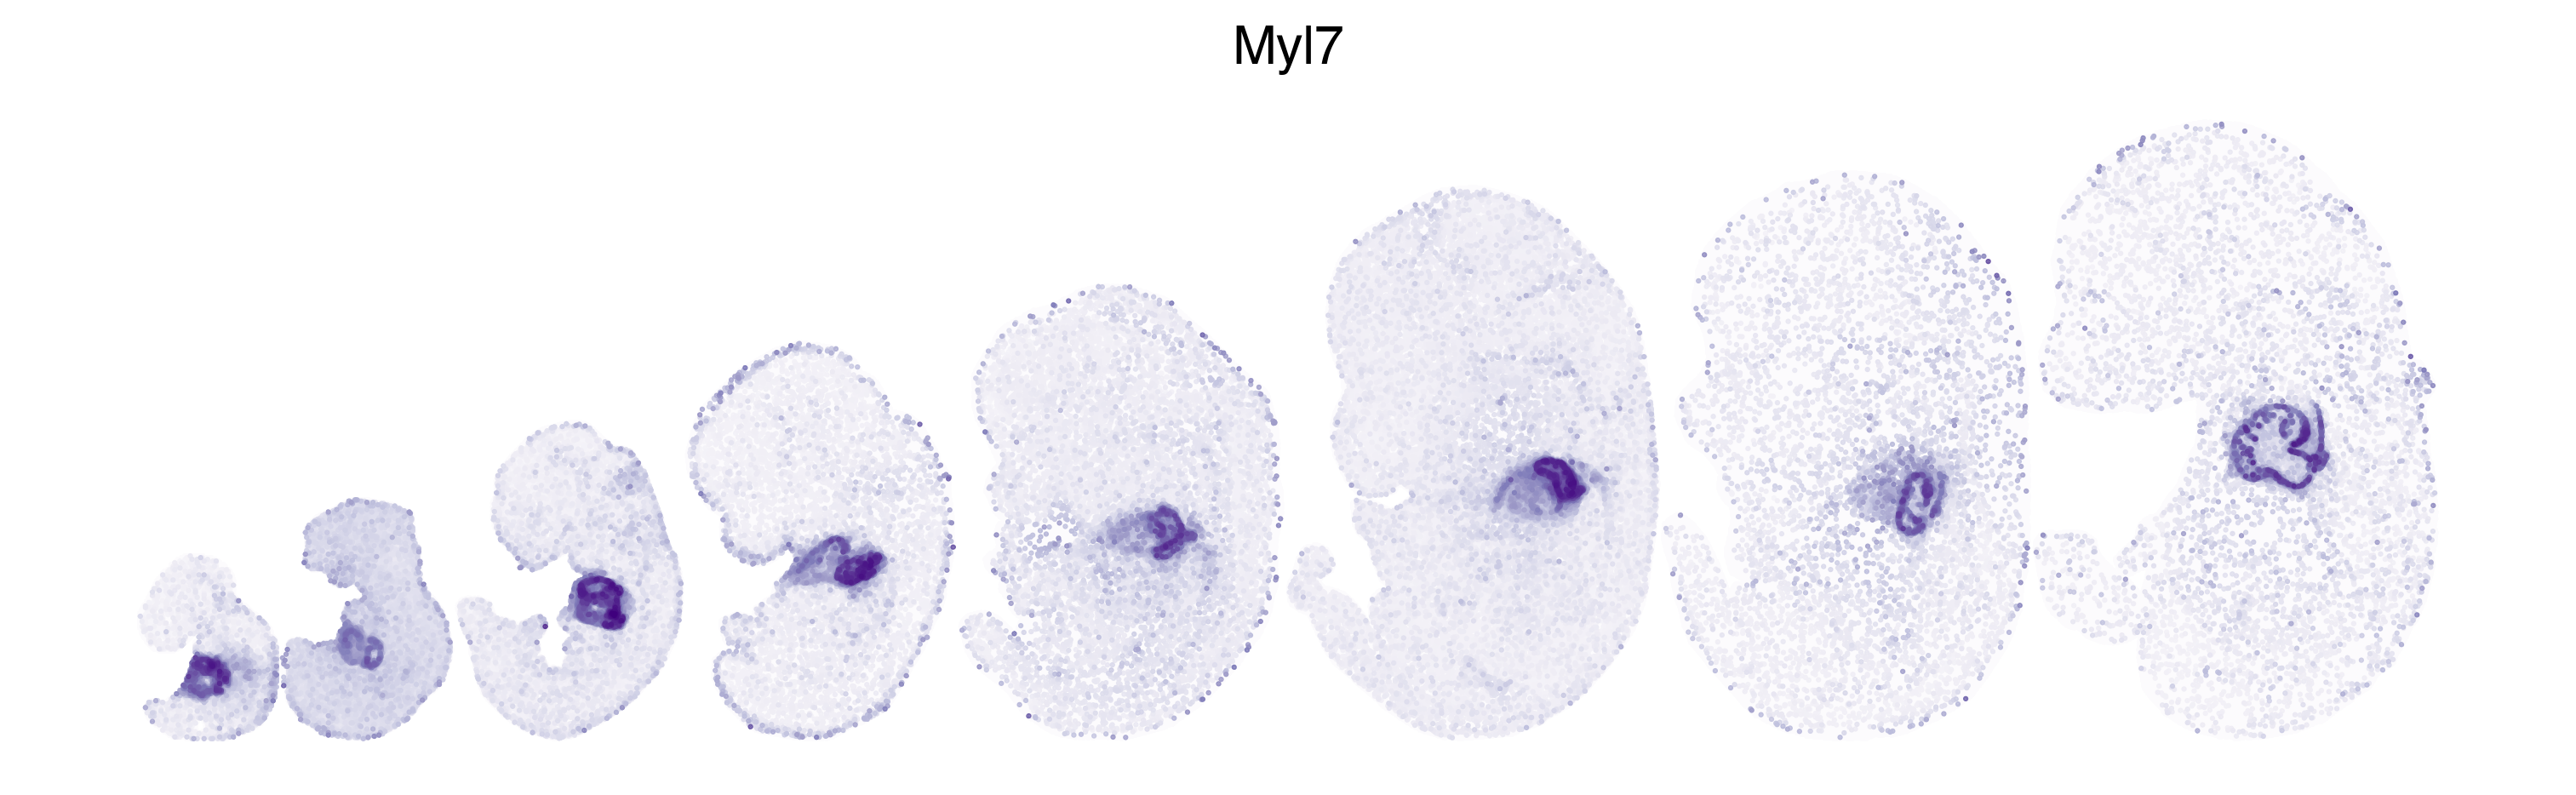

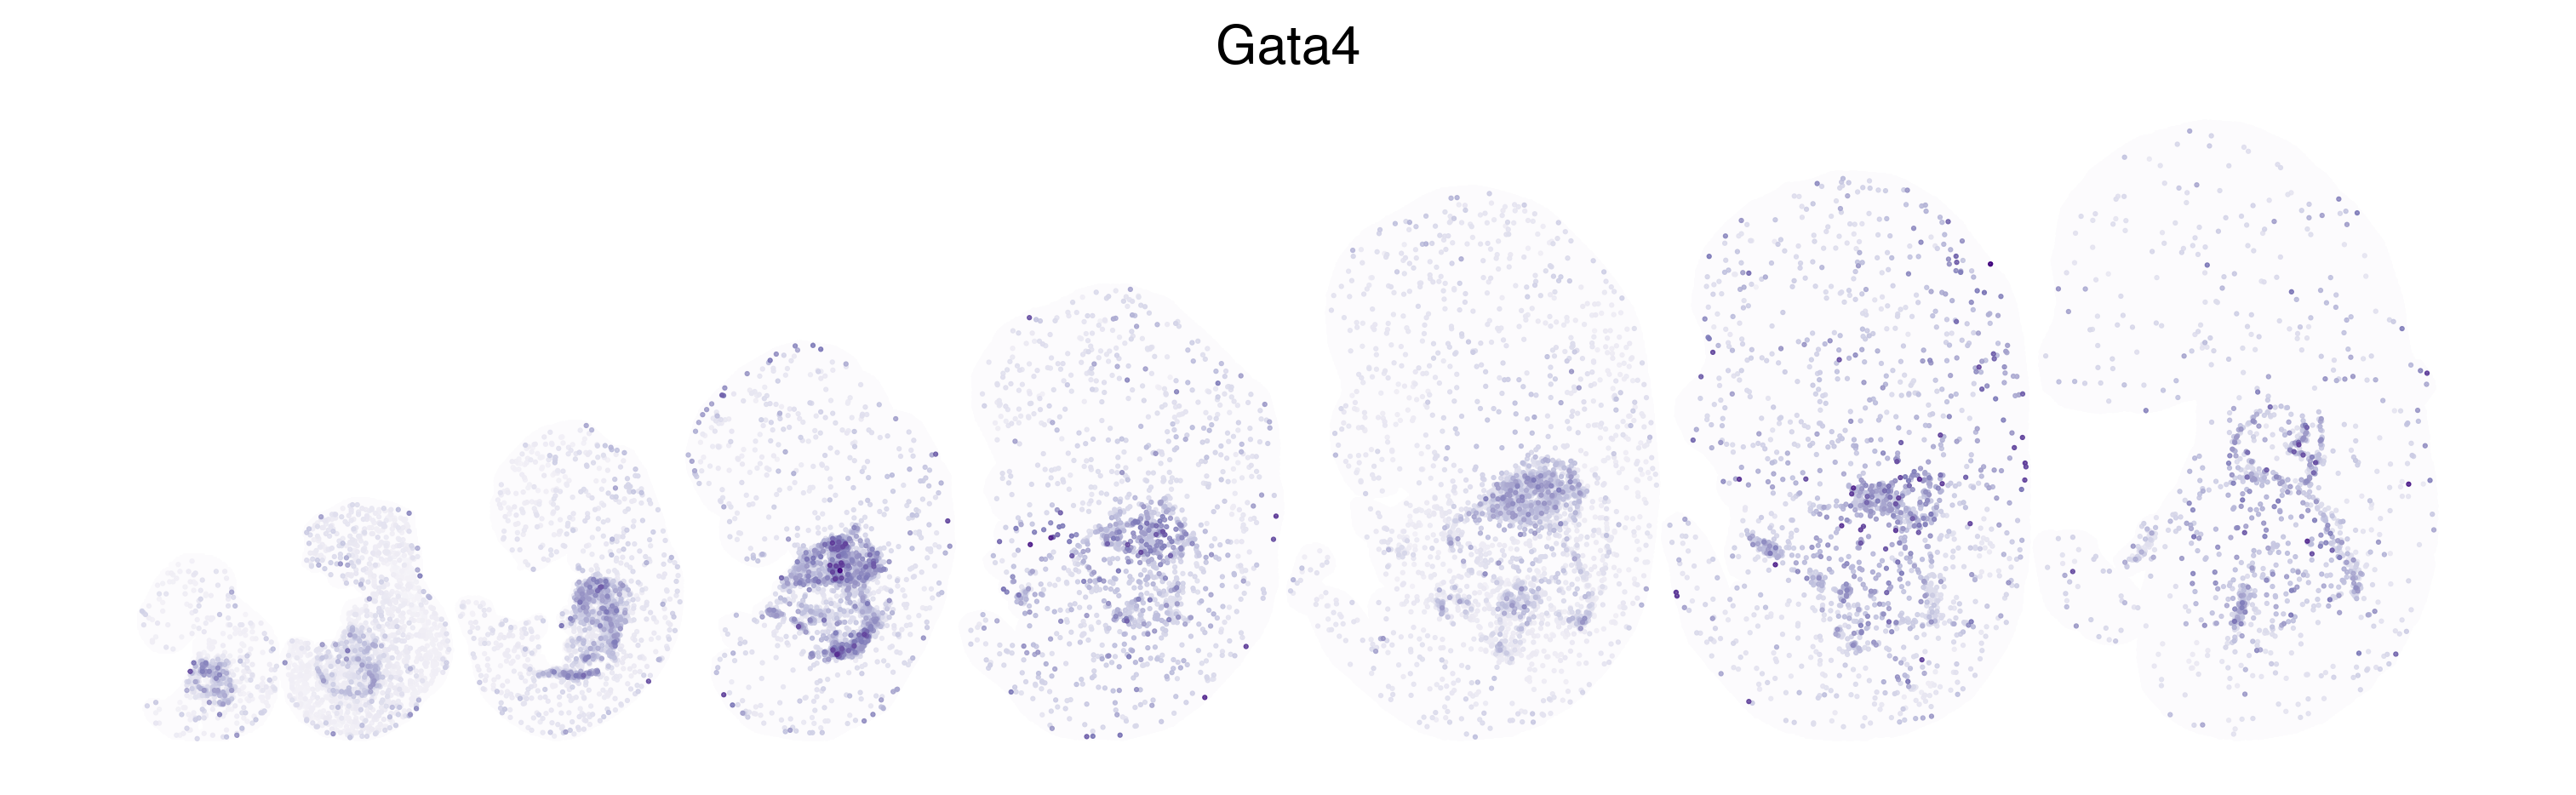

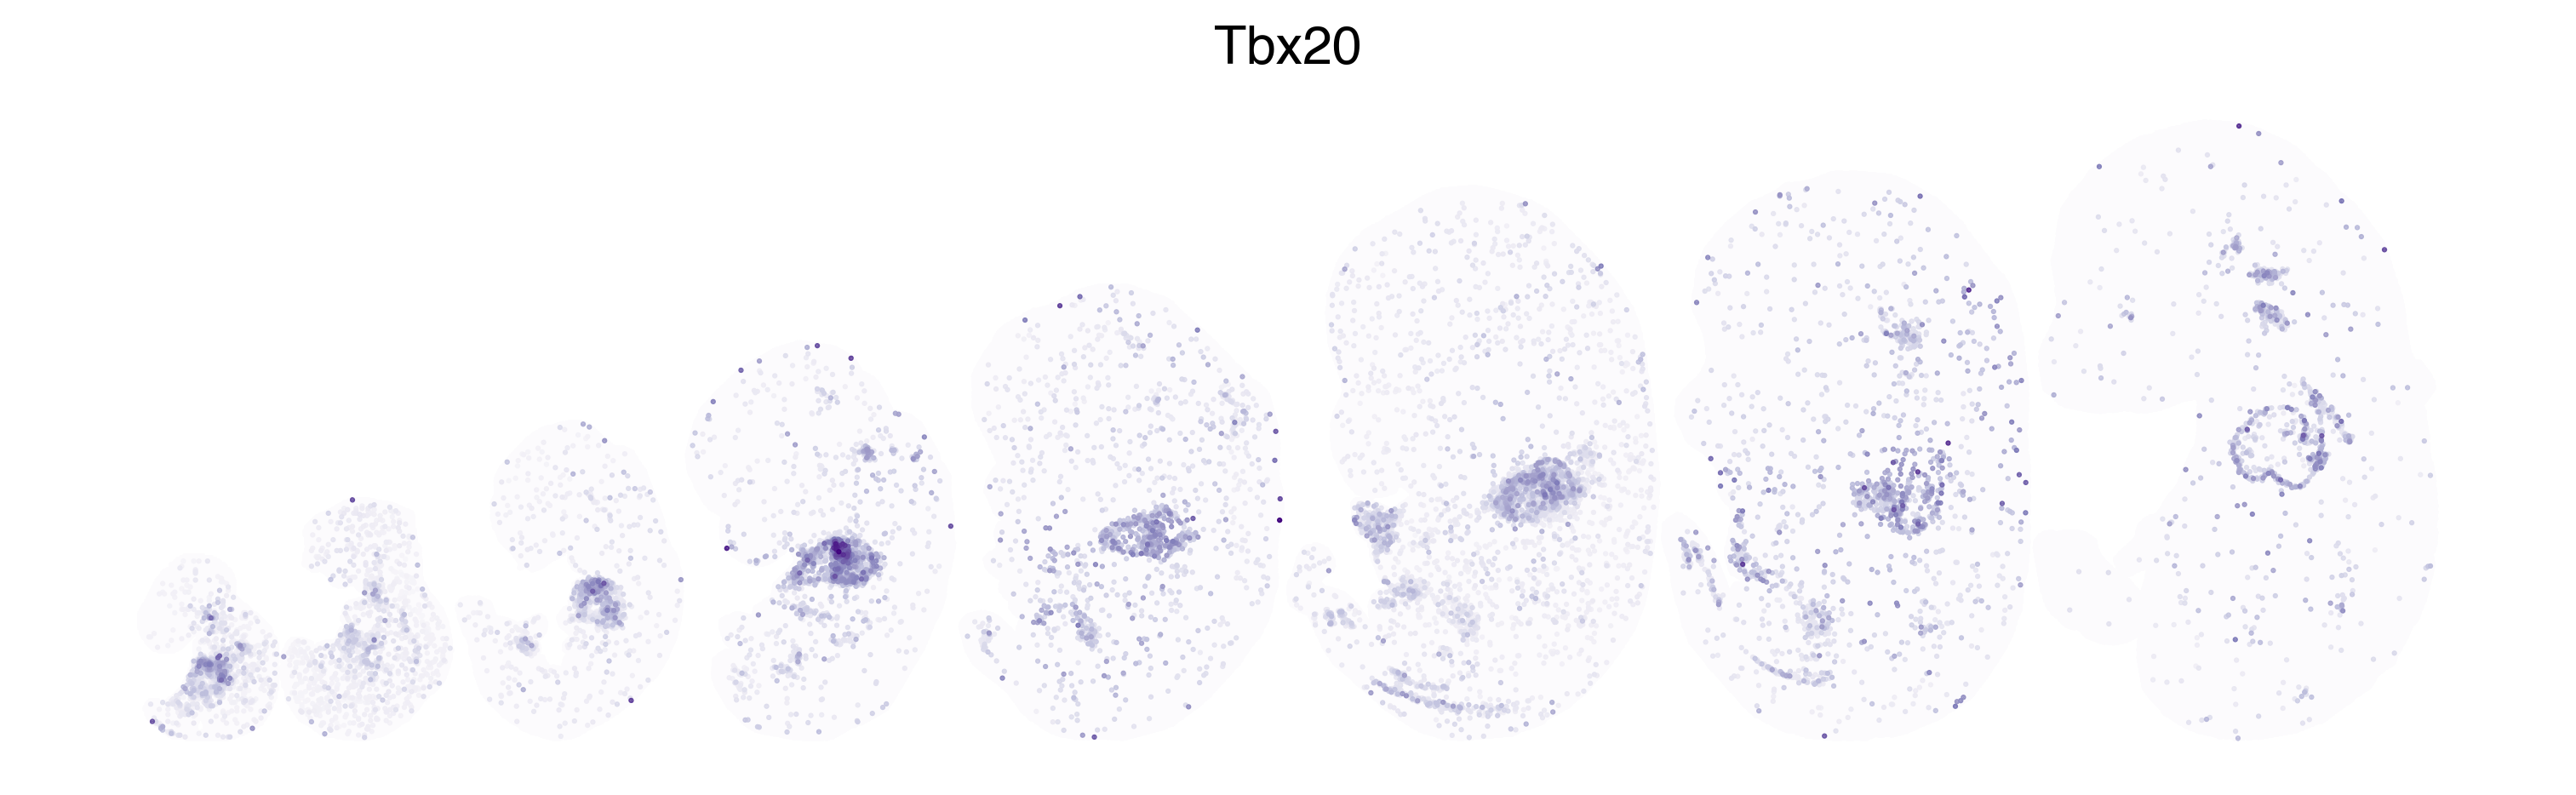

In [33]:
for gene in ["Myh6", "Myl7", "Gata4", "Tbx20"]:
    sq.pl.spatial_scatter(
        adata[adata[:, gene].X.A.flatten().argsort()],
        shape=None,
        color=gene, 
        frameon=False,
        cmap="Purples",
        size=1,
        figsize=(18, 3),
        dpi=300,
        colorbar=False,
    )
    
    if save_figure:
        plt.savefig(FIG_DIR + f"heart_{gene}.png", bbox_inches="tight", transparent=True, dpi=300)
    plt.show()

## Plot `heart` fate

In [34]:
adata.obs["Heart_annot_plotting"] = pd.Categorical(
    adata.obs.annotation.isin(["Heart"]), categories={True: "Heart", False: np.nan}
)
adata.uns["Heart_annot_plotting_colors"] = [
    adata.uns["annotation_colors"][
        adata.obs.annotation[adata.obs.annotation.isin(["Heart"])].cat.codes[0]
    ],
    "lightgrey",
]

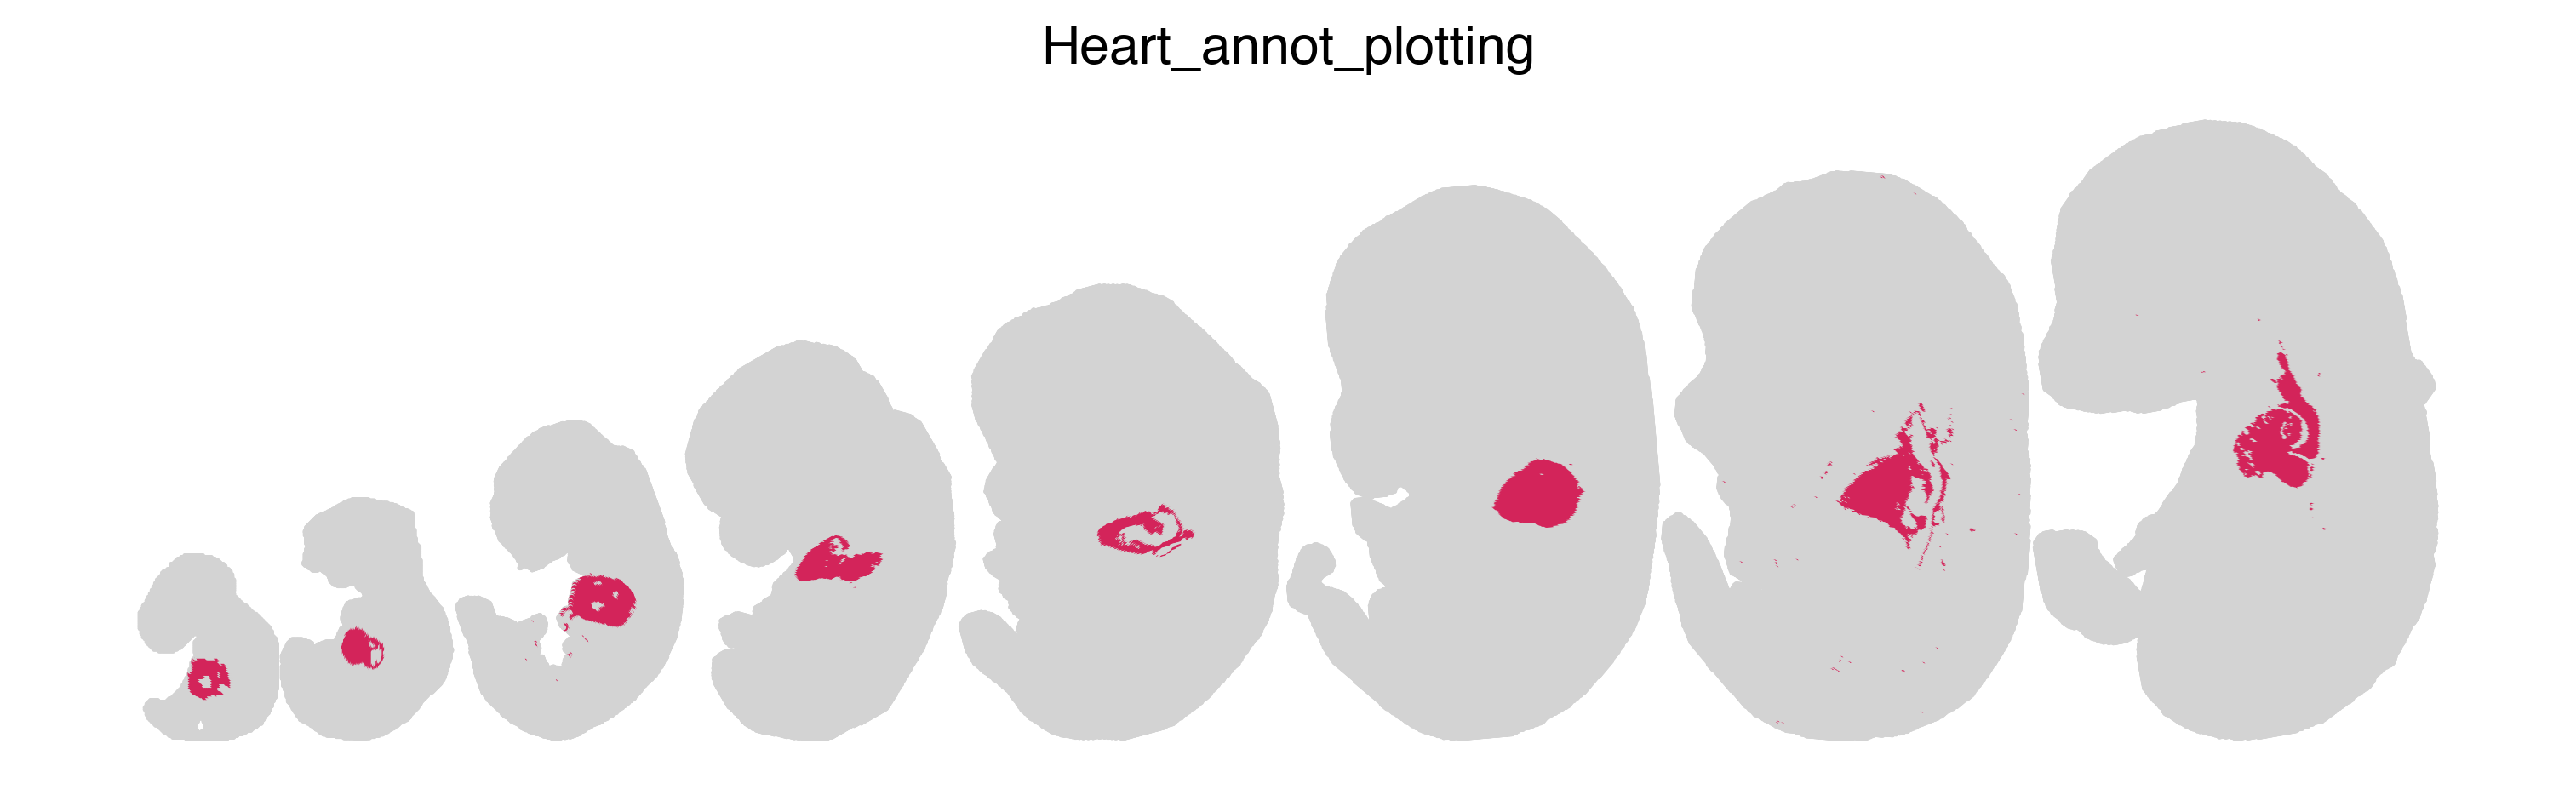

In [35]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["Heart_annot_plotting"],
    na_color="lightgrey",
    size=1,
    frameon=False,
    figsize=(18, 3),
    dpi=300,
    legend_loc=None,
)
    
if save_figure:
    plt.savefig(FIG_DIR + f"heart_annotation.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

In [36]:
for state in g.absorption_probabilities.names:
    adata.obs[f"fate_probs_{state}"] = g.absorption_probabilities[state].X.flatten()

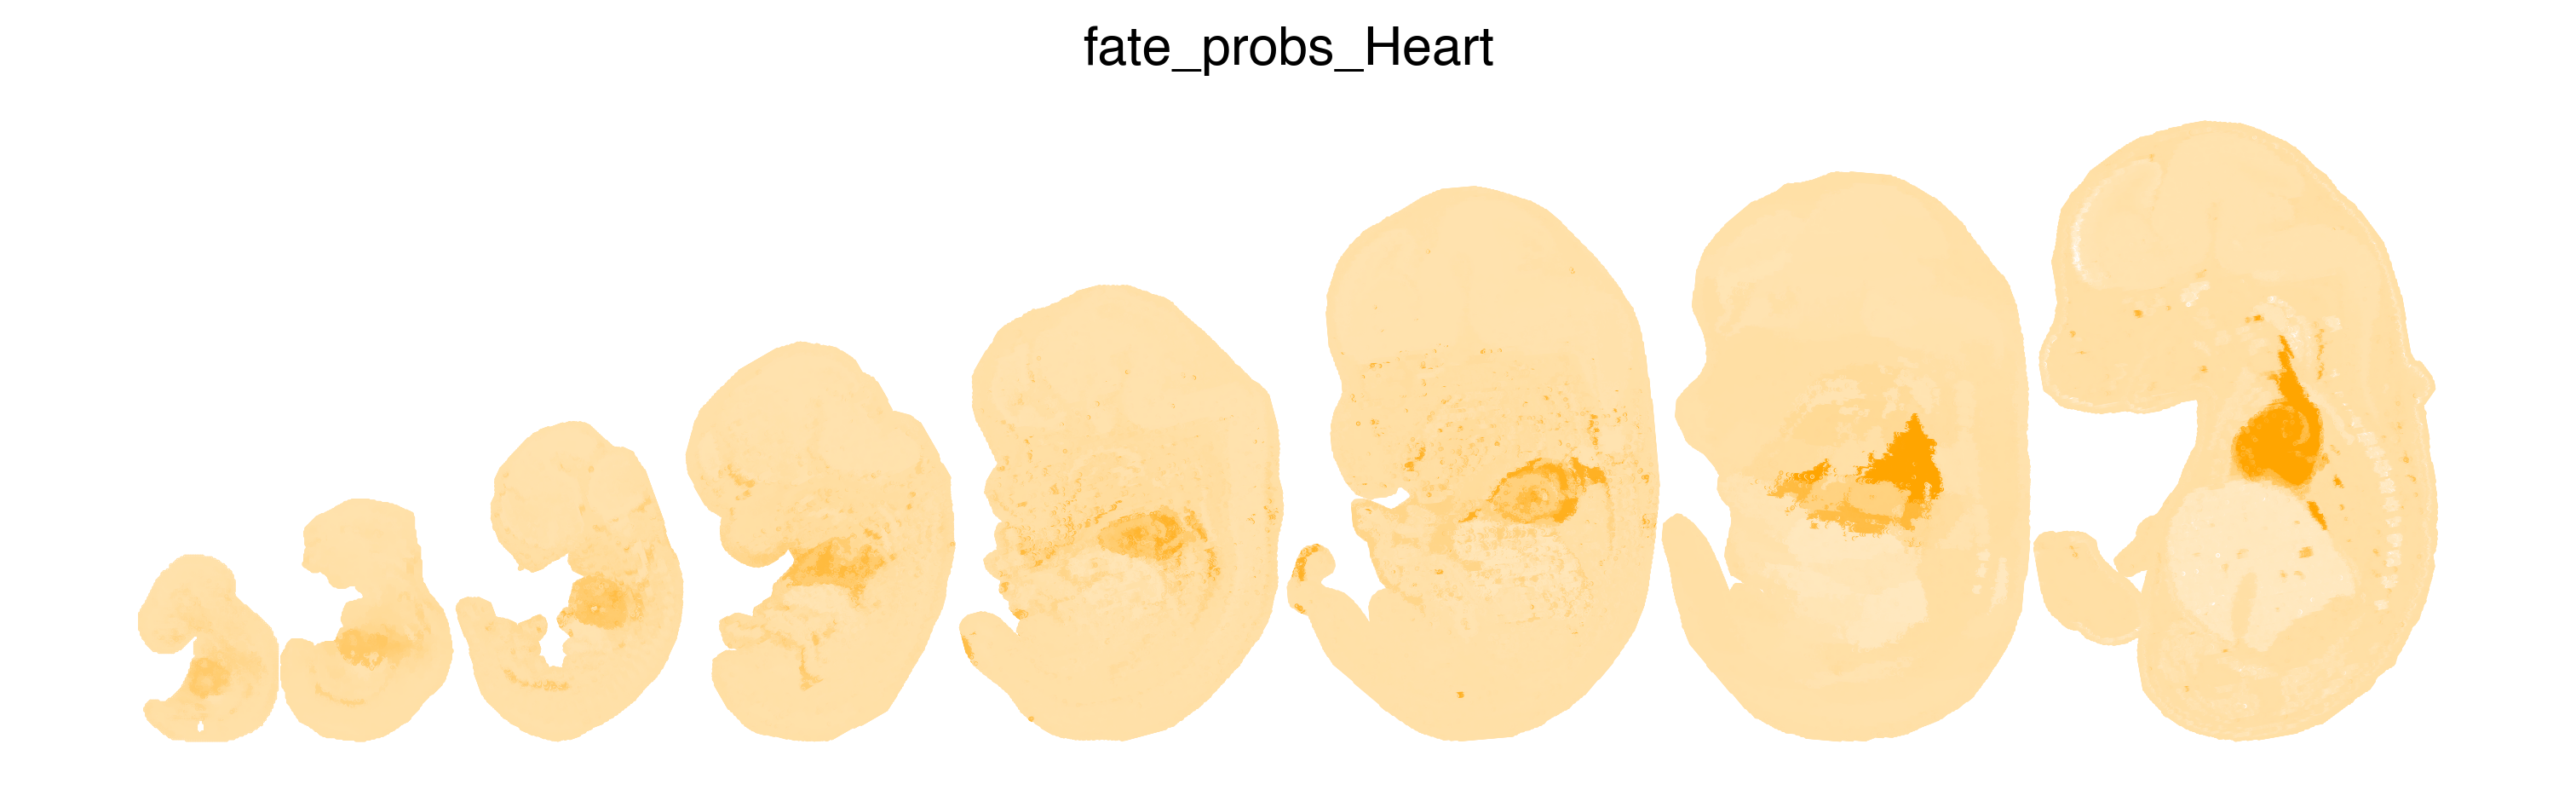

In [37]:
sq.pl.spatial_scatter(
    adata[adata[:, gene].X.A.flatten().argsort()],
    shape=None,
    color="fate_probs_Heart", 
    frameon=False,
    cmap=sns.blend_palette(["#FFFFFF", "#FFA500"], as_cmap=True),
    vmax=0.5,
    figsize=(18, 3),
    dpi=300,
    colorbar=False,
)
    
if save_figure:
    plt.savefig(FIG_DIR + f"heart_fate.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

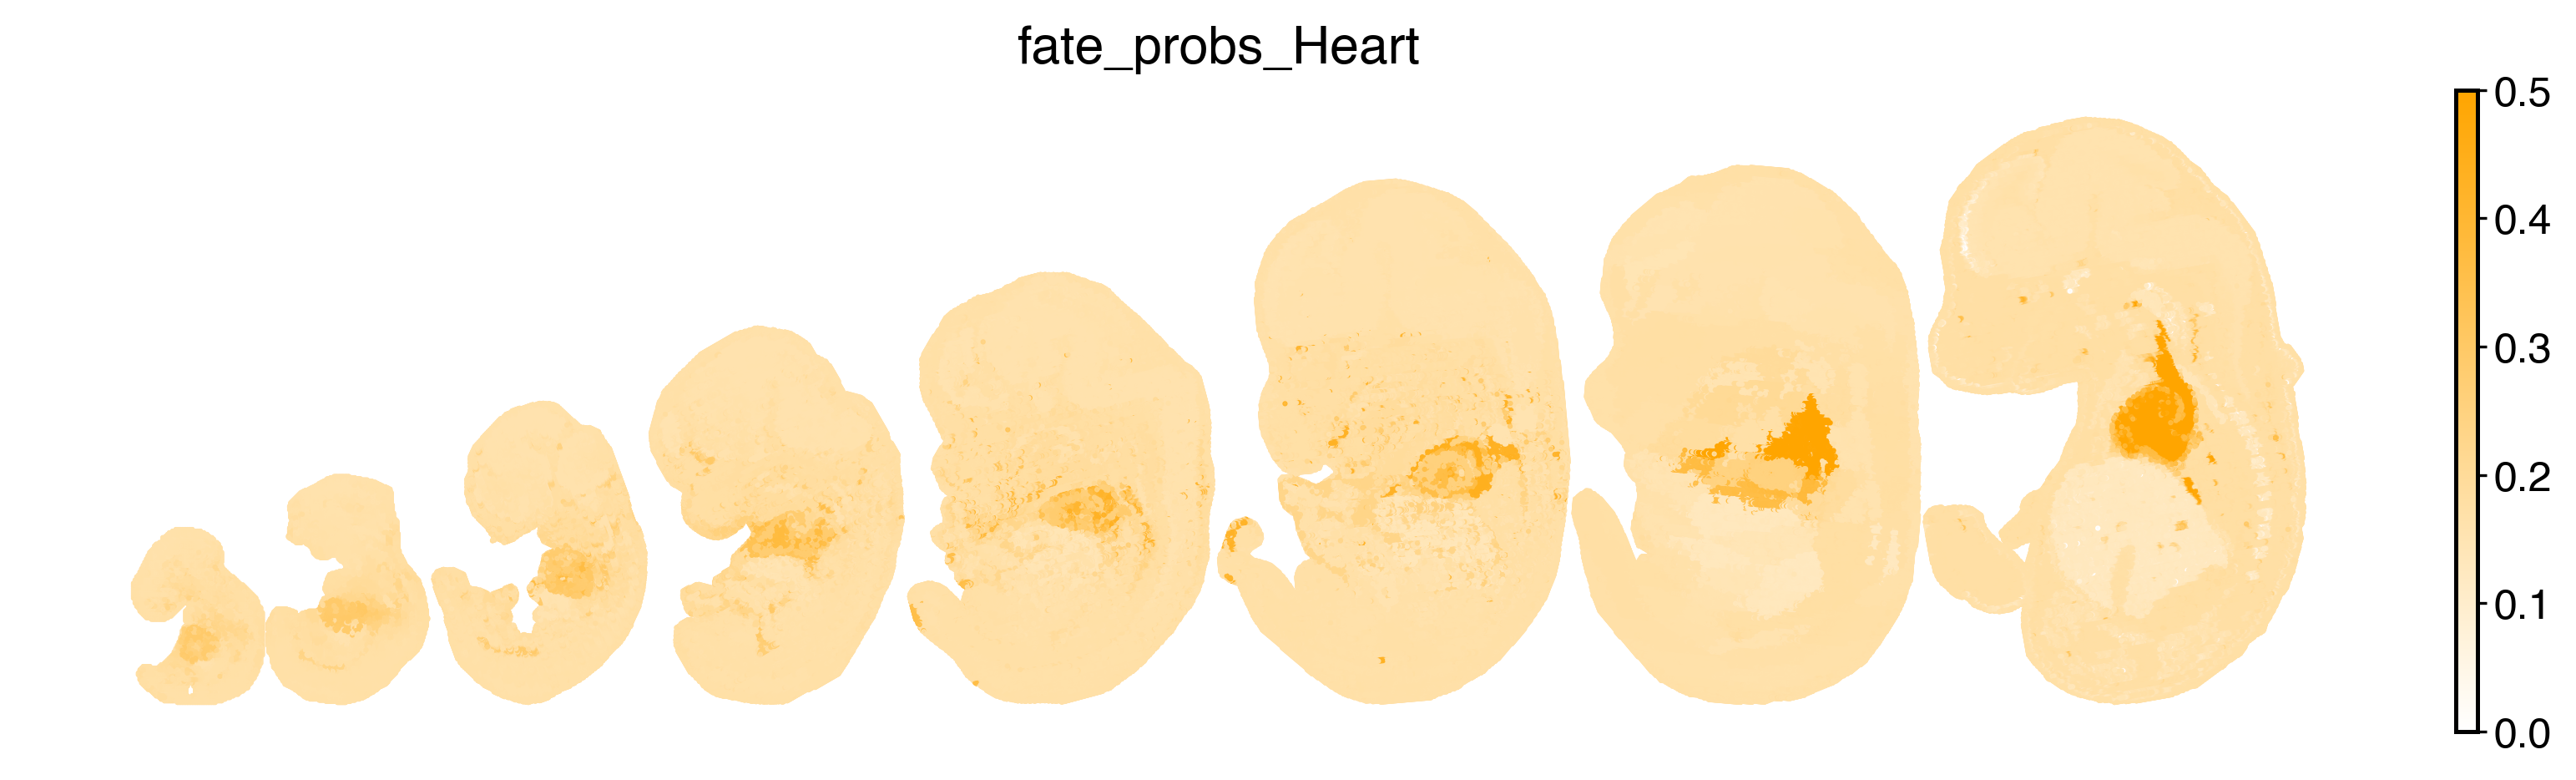

In [38]:
sq.pl.spatial_scatter(
    adata[adata[:, gene].X.A.flatten().argsort()],
    shape=None,
    color="fate_probs_Heart", 
    frameon=False,
    cmap=sns.blend_palette(["#FFFFFF", "#FFA500"], as_cmap=True),
    vmax=0.5,
    size=1,
    figsize=(18, 3),
    dpi=300,
    colorbar=True,
)
    
if save_figure:
    plt.savefig(FIG_DIR + f"heart_fate_cbar.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

[[1] Ao Chen, Sha Liao, Mengnan Cheng, Kailong Ma, Liang Wu, Yiwei Lai, Xiaojie Qiu et al. "Spatiotemporal transcriptomic atlas of mouse organogenesis using DNA nanoball-patterned arrays." Cell (2022)](https://doi.org/10.1016/j.cell.2022.04.003)